# HW Tool

## 1. `shap.plots.beeswarm` нормального человека (6 баллов)

Как вы могли видеть, у встроенного beeswarm plot`а есть несколько недостатков:
- нет информации о том, какие именно значения категориальных признаков в какую сторону толкают предсказания модели
- иногда серые точки (пропущенные значения) прячутся за точками другого цвета -> их не видно (см. rooms_num на графике с семинара)
- иногда раскраска бывает некорректной (потому что она раскрашивает по абсолютным значениям)

Вам предлагается реализовать свою версию shap.plots.beeswarm, которая исправляет эти недостатки.


Итак, требуется написать функцию, которая принимает на вход shap_values и все необходимое и строит по этим данным beeswarm plot
    без вышеперечисленных недостатков, а именно:
- теперь все уникальные значения кат. фич становятся как бы отдельными фичами, по ним видны shap_values (см. пример)
    - чтобы не захламлять ваш график редковстречающимися категориями, принимайте на вход параметр, чтобы контролировать это
    - такие фичи должны быть покрашены в особый цвет, чтобы отличаться от числовых
- точки, отвечающие за наны, должны быть хорошо видны на фоне остальных и не перекрывать их
- раскраска должна адекватно красить ваши точки
    - можно выкидывать выбросы перед покраской
    - можно логарифмировать значения
    - можно красить по квантилям, а не по абсолютным значениям
    - лучше всего красятся равномерное и нормальное распределение

**Обязательно:**
- docstring
- комменты к непонятным кускам кода - что там происходит
- принимайте на вход кол-во фич, которые вы отображаете на графике
- принимайте на вход размер фигуры
- нарисуйте вертикальную линию, обозначающую 0
- сортируйте признаки по среднему модулю shap_values
- используйте stripplot (или аналоги) с jitter`ом, а не swarmplot
- принимайте на вход кол-во точек которое будете отрисовывать (500-3000 = норм)
    - если для какого-то значения кат фичи точек меньше, чем вы задали, рисуйте сколько есть

**!**
Если на вход подана слишком большая выборка, вы можете под капотом сэмплить из нее какое-то адекватное кол-во точек и отрисовывать их.
Однако, раскраску и контроль за отрисовкой категорий лучше базировать на всей выборке, поданной на вход.


Ниже приведен пример. Не меняйте код, предшествующий примеру. Вы не обязаны повторять пример точь-в-точь, это ориентир. Не удаляйте пример.

Удачи!

In [1]:
import numpy as np, pandas as pd
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


df = pd.read_parquet('train_sber.parquet')
features = df.columns.drop(['timestamp', 'result_price', 'result_price_bin'])

model = lgb.Booster(model_file='model.lgb')
shap_values = model.predict(df[features], pred_contrib=True)
            
'''
Учтите, что если вы считаете shap_values через LightGBM,
    shap_values - np.array of shape (N, F + 1), где последний столбец - константа = среднее предсказание для всех объектов
'''
print('features shape:', features.shape, 'shap_values shape:', shap_values.shape)
df.head(3)

[LightGBM] [Warning] Ignoring unrecognized parameter 'bagging_by_query' found in model string.
features shape: (36,) shap_values shape: (27232, 37)


,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance,result_price_bin
0,6407578.100,1.422391,3.830951,NaN,13.675657,24.292406,152,0.485841,4.0,86206,...,3.299822,13.100618,0.177975,52,NaN,Bibirevo,2011-08-20,52,14.231961,False
1,9589336.912,2.887377,3.103996,NaN,8.132640,5.706113,177,0.668364,3.0,76284,...,0.783160,6.444333,0.273345,66,NaN,Nagatinskij Zaton,2011-08-23,40,9.242586,False
2,4808269.831,0.647250,2.927487,NaN,8.054252,6.710302,122,0.733101,2.0,101982,...,3.945073,6.963403,0.158072,67,NaN,Tekstil'shhiki,2011-08-27,35,9.540544,False


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def my_beeswarm(
    df: pd.DataFrame,
    features: list,
    shap_values: pd.DataFrame,
    cat_feature_threshold: float,
    top_k: int,
    figsize: tuple,
    dots: int,
    alpha_outliers: float = 0.1,
    random_seed: int = None,
):
    """
    Аналог shap.plots.beeswarm с адекватной отрисовкой категориальных признаков и пропущенных значений.

    Args:
        df (pd.DataFrame): Исходный датасет.
        features (list): Список признаков.
        shap_values (pd.DataFrame): Датафрейм с SHAP-значениями для модели LightGBM.
        cat_feature_threshold (float): Порог для определения достаточно "популярных" категорий.
            Категории с долей <= `cat_feature_threshold` не отрисовываются.
        top_k (int): Количество признаков для отрисовки.
        figsize (tuple): Размер графика.
        dots (int): Количество точек, отображаемых для каждого признака.
        alpha_outliers (float): Уровень квантилей для отсечения выбросов при нормализации цветовой шкалы.
            Берутся квантили уровней `alpha_outliers` и `1 - alpha_outliers` соответственно.
            По умолчанию: `0.1`.
        random_seed (int): random_seed для воспроизводимости сэмплинга точек. По умолчанию: `None`.


    Notes:
        - Для категориальных признаков используется зеленая заливка.
        - Пропущенные значения признаков (`NaN`) отображаются черными точками.
        - Цветовая шкала для числовых признаков нормализуется через `AsinhNorm`.
    """
    df = df[features].copy()
    random_state = np.random.RandomState(random_seed)

    # определение категориальных и числовых признаков
    # + вычисление квантилей для нормализации отрисовки числовых признаков
    num_features, cat_features = [], []
    num_feat_quantiles = {}
    for feature in features:
        if isinstance(df[feature].dtype, pd.CategoricalDtype):
            cat_features.append(feature)
        else:
            num_features.append(feature)
            tmp = df[feature]
            num_feat_quantiles[feature] = (
                tmp.quantile(q=alpha_outliers),
                tmp.quantile(q=1 - alpha_outliers),
            )

    # отбрасывание последней колонки в шапах
    shap_df = pd.DataFrame(shap_values[:, :-1], columns=features)

    # создание dummy фичей для "популярных" категорий
    new_dummy_feats = []
    for feature in cat_features:
        vc = df[feature].value_counts(normalize=True)
        new_columns, shap_new_cols = {}, {}
        for feat_value in vc.keys():
            if vc[feat_value] > cat_feature_threshold:
                new_feat_name = f"{feature}_{feat_value}"
                new_dummy_feats.append(new_feat_name)
                idx = df[feature] == feat_value
                new_columns[new_feat_name] = idx.astype(int)
                shap_new_cols[new_feat_name] = shap_df[feature][idx]

        df = pd.concat(
            [df.drop(feature, axis=1), pd.DataFrame(new_columns)], axis=1
        )

        shap_df = pd.concat(
            [shap_df.drop(feature, axis=1), pd.DataFrame(shap_new_cols)],
            axis=1,
        )

    # сортировка признаков по убыванию среднего модуля шапов
    total_sorted_features = (
        abs(shap_df)
        .mean(axis=0)
        .sort_values(ascending=False)
        .index.to_list()[:top_k]
    )

    # подготовка данных к отрисовке
    plot_data = pd.concat(
        [
            shap_df[total_sorted_features].melt(
                var_name="feature", value_name="shap_value"
            ),
            df[total_sorted_features].melt(
                var_name="feature", value_name="feature_value"
            )["feature_value"],
        ],
        axis=1,
    )

    _, ax = plt.subplots(figsize=figsize)

    for i, feature in enumerate(total_sorted_features):
        ax.axhline(y=i, color="gray", alpha=0.25)

        # в dummy признаках если значение 0, то SHAP полагается равным NaN,
        # поэтому для корректной отрисовки необходимого числа точек нужно проворачивать следующий трюк:
        cur_plot = plot_data[
            (plot_data["feature"] == feature)
            & ~(plot_data["shap_value"].isna())
        ]
        cur_plot = cur_plot.sample(
            n=min(dots, cur_plot.shape[0]),
            replace=False,
            random_state=random_state,
        )

        # отрисовка кат. признаков
        if feature in new_dummy_feats:
            sns.stripplot(
                data=cur_plot,
                x="shap_value",
                y="feature",
                ax=ax,
                jitter=0.1,
                legend=False,
                color="green",
                alpha=0.5,
                size=3.5,
            )
        else:
            vmin, vmax = num_feat_quantiles[feature]
            nan_idx = cur_plot["feature_value"].isna()
            # отрисовка числовых признаков
            sns.stripplot(
                data=cur_plot[~nan_idx],
                x="shap_value",
                y="feature",
                ax=ax,
                hue="feature_value",
                hue_norm=mpl.colors.AsinhNorm(
                    vmin=vmin, vmax=vmax, clip=True
                ),  # нормализация цветовой шкалы
                palette="coolwarm",
                jitter=0.2,
                legend=False,
                alpha=0.75,
                size=3.5,
            )
            # отрисовка пропущенных значений
            sns.stripplot(
                data=cur_plot[nan_idx],
                x="shap_value",
                y="feature",
                ax=ax,
                color="black",
                jitter=0.05,
                legend=False,
                alpha=1,
                size=3.5,
            )
    # добавление цветовой шкалы в легенде
    sm = plt.cm.ScalarMappable(
        cmap="coolwarm", norm=mpl.colors.Normalize(vmin=0, vmax=1)
    )
    sm.set_array([])
    plt.colorbar(sm, ax=ax)
    ax.set_ylabel("Features")
    ax.set_xlabel("SHAP values")
    ax.axvline(x=0)
    plt.show()


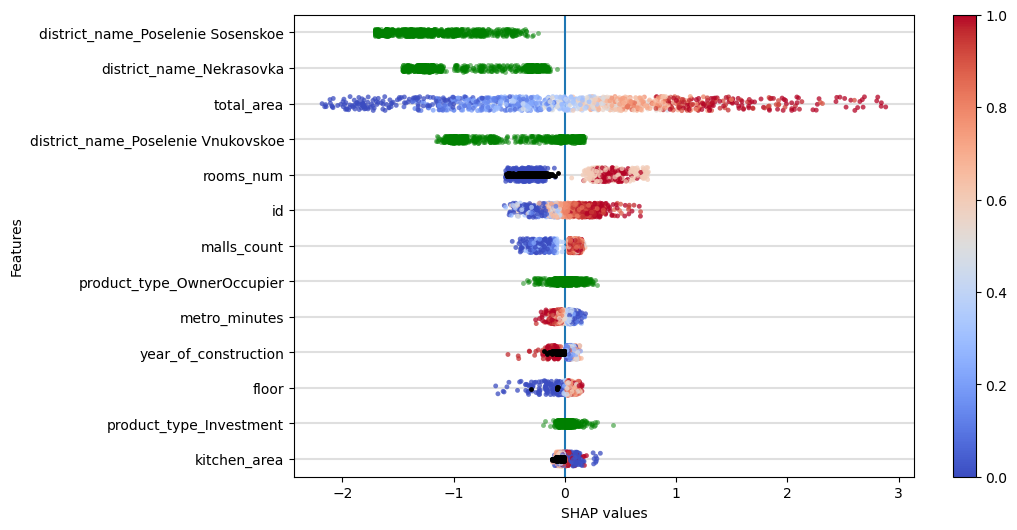

In [4]:
# ваш пример
my_beeswarm(df, features, cat_feature_threshold=0.03, shap_values=shap_values, top_k=13, figsize=(10,6), dots=1000, random_seed=42)

Пример ниже. Не удаляйте пример!

CPU times: total: 1.61 s
Wall time: 1.61 s


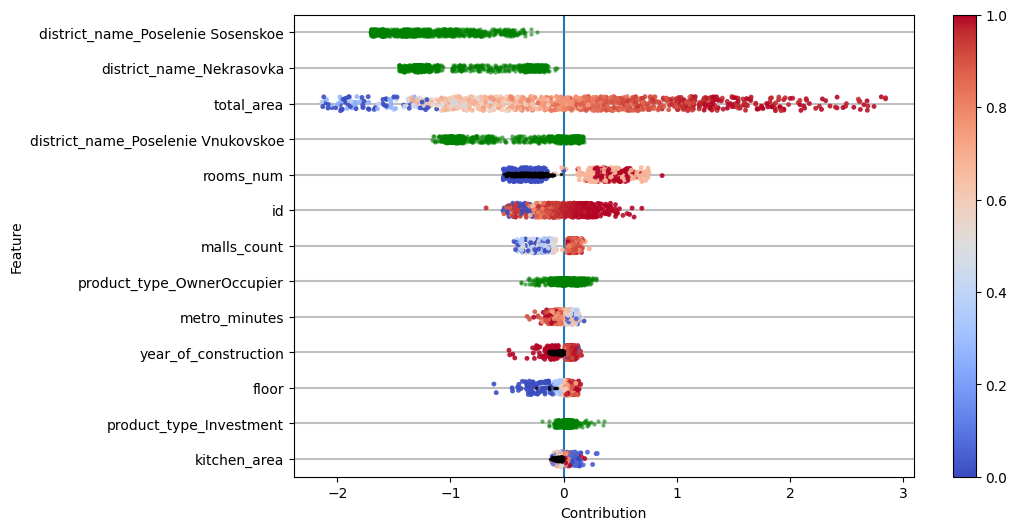

In [28]:
%%time
from utils import shap_beeswarm

shap_beeswarm(model, df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

## 2. Логирование градиентов при обучении (4 балла)

**Задача:** хотим для каждого объекта для каждого дерева получить gi - производную лосса!
Чтобы:
- нарисовать карту объект-дерево
- поизучать 2D-представления
- призадуматься...

**Как:** придумайте способ! Нужно в процессе обучения сохранять градиенты LogLoss`а объектов на каждом дереве, после чего продемонстрировать собранные градиенты с помощью sns.clustermap. 

Ниже пример. Не удаляйте пример!

In [5]:
# your code here
from scipy.special import expit

def somehow_get_grads(params: dict, train: lgb.Dataset):
    """
    Логирование градиентов на каждой итерации для модели LightGBM

    Args:
        params (dict): Параметры модели.
        train (lgb.Dataset): Обучающая выборка.

    Returns:
        grads (np.array): Массив градиентов на каждой итерации.

    Тонкость реализации:
        - Функция реалиована с помощью кастомного objective для модели LightGBM. 
        Помимо вычисления градиента происходит запись градиента в массив.
    """
    params = params.copy()
    grads = []

    def custom_log_loss_grad_hess(y_raw, tr_data=None, y_true=None):
        # функция взята из семинара по кастомным лоссам
        if y_true is None:
            y_true = tr_data.get_label()
        y_prob = expit(y_raw)
        
        grad = y_prob - y_true
        hess = y_prob * (1 - y_prob)

        # дополнение к функции с семинара, сохраняющее производную
        grads.append(grad.copy())
        
        return grad, hess

    params['objective'] = custom_log_loss_grad_hess
    params['verbosity'] = -1

    # иззбавление от warning'ов:
    # 'categorical_feature' выпилят в новой версии LGBM, его надо прописывать в lgb.Dataset
    keys = list(params.keys())
    num_iterations = 100
    if 'categorical_feature' in keys:
        params.pop('categorical_feature')
    if 'num_iterations' in keys:
        num_iterations = params['num_iterations']
        params.pop('num_iterations')

    lgb.train(
        params=params,
        num_boost_round=num_iterations,
        train_set=train,
    )

    return np.array(grads)

### Мой пример:

In [6]:
def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin, categorical_feature=model.params['categorical_feature'])

grads = somehow_get_grads(model.params, lgb_tr)
grads.shape

(300, 20968)

CPU times: total: 1min 33s
Wall time: 2min 7s


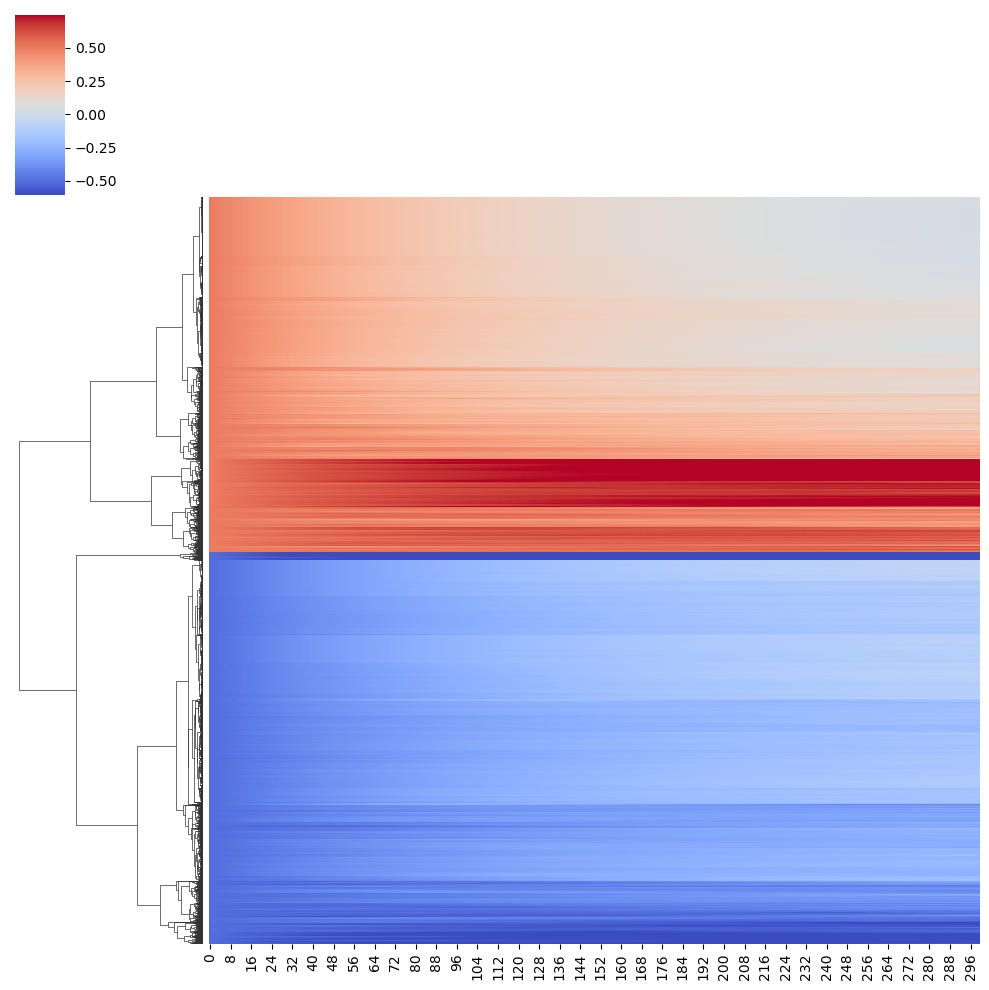

In [7]:
%%time
import seaborn as sns

sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

Пример. Не удаляйте пример!

In [104]:
def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads()
grads.shape

(100, 20968)

CPU times: total: 1min 17s
Wall time: 1min 17s


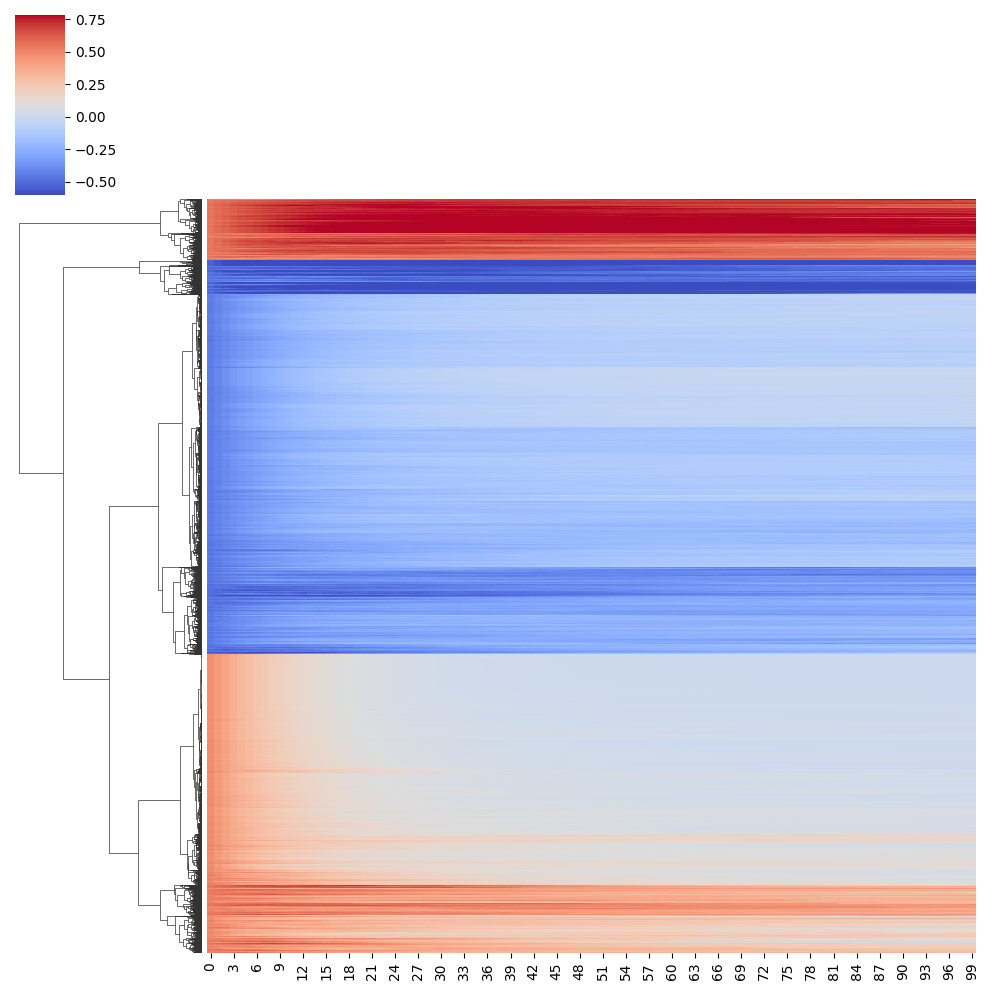

In [102]:
%%time
import seaborn as sns

# предварительно установите fastcluster: pip install fastcluster, иначе считаться будет долго
sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

## 3. Автоматическое создание весов для бинарной классификации (5 баллов)

В этом блоке ваша цель - написать функцию, которая генерирует вектор весов для объектов обучающей выборки следующим образом:
1) на вход подается таргет-колонка и произвольная колонка
2) если колонка числовая, бьем ее на бины (кол-во бинов `bins` принимаем на вход. берем небольшое, около 7-13)
    - если в колонке < `bins` уникальных, бить не надо 
3) если колонка категориальная, тоже бьем ее на бины
    - если уникальных значений <= `bins`, то за бины считаем уникальные значения категории
    - если уникальных значений >  `bins`, то выбираем `bins` - 1 самых популярных категорий у объектов класса 1
    - не попавшие в топ самых популярных категории запихиваем в бин 'other'

4) проходимся по всем бинам, присваивая всем объектам класса 1, попавшим в бин, вес n_0_in_bin / n_1_in_bin,
       если объектов класса 0, попавших в этот бин, достаточное кол-во (принимайте на вход, зависит от задачи)

5) всем объектам класса 0 присваиваем вес, равный единице

Такая схема на практике работает лучше, чем обычный `scale_pos_weight` параметр в LightGBM и его аналоги, если разумно выбирать
    вспомогательную колонку. Подумайте, как именно нужно выбирать такую колонку. Ответ писать не обязательно, но можно :)

**Обязательно:**
Найдите способ продемонстрировать визуализацией, что ваша функция работает корректно!

In [ ]:
def generate_weights(target: pd.Series, hue: pd.Series, bins: int, min_n_0: int):
    """
    Функция, генерирующая веса для объектов

    Args:
        target (pd.Series): столбец таргетов.
        hue (pd.Series): столбец, по которому происходит присваивание весов.
        bins (int): число бинов, на которые бьётся колонка hue.
        min_n_0 (int): минимальное число объектов класса 0, которое может попасть в бин
        (если n_0_in_bin < min_n_0, то объектам класса 1 в бине присваивается единичный вес).

    Returns:
        weights (np.array): массив весов для всех объектов выборки.
    """
    weights = np.ones(shape=target.shape[0])
    bins_idx = []
    if hue.nunique() > bins:
        if isinstance(hue.dtype, pd.CategoricalDtype):
            objs = hue[target == 1]
            top_cats = objs.value_counts().sort_values(ascending=False).keys()[:bins - 1]
            bins_idx = [(hue == value) for value in top_cats]
            bins_idx.append(~hue.isin(top_cats))
        else:
            bins_ranges = pd.cut(hue, bins=bins, retbins=True)[1]
            for i in range(len(bins_ranges) - 1):
                if i == 0:
                    bins_idx.append((hue >= bins_ranges[i]) & (hue <= bins_ranges[i + 1]))
                else:
                    bins_idx.append((hue > bins_ranges[i]) & (hue <= bins_ranges[i + 1]))
    else:
        bins_idx = [(hue == value) for value in np.unique(hue.values)]

    for idx in bins_idx:
        ones_idx = (target[idx] == 1)
        n_0_in_bin = (~ones_idx).sum()
        n_1_in_bin = ones_idx.sum()

        if n_0_in_bin >= min_n_0 and n_1_in_bin > 0:
            weights[ones_idx[ones_idx].index] = n_0_in_bin / n_1_in_bin

    return weights

### Визуализация
Возьмём числовой признак (например, `bulvar_ring_km`) и построим по нему веса (единственное, чем отличается случай числовой и категориальной переменной - разбиением на бины. Я демонстрирую корректность работы функции на числовом признаке только потому, что разбиение на бины можно удобно продемонстрировать с помощью гистограммы). Далее построим гистограмму для этого признака (с таким же числом бинов как при генерации весов) с разбиением по таргету, после чего нарисуем веса для каждого объекта, выделяя цветом принадлежность к классу 0 или 1.

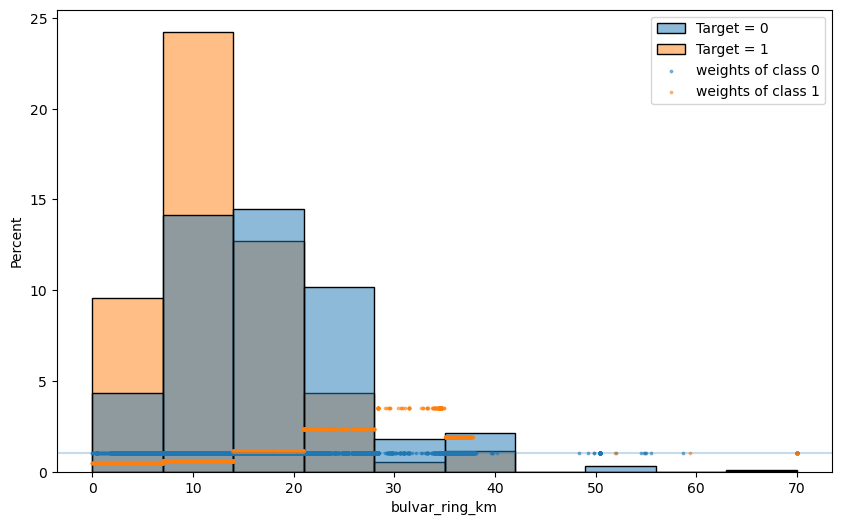

In [9]:
weights = generate_weights(df['result_price_bin'], df['bulvar_ring_km'], 10, 100)

idx_0 = (df['bulvar_ring_km'].loc[df['result_price_bin'] == 0]).sort_values().index
idx_1 = (df['bulvar_ring_km'].loc[df['result_price_bin'] == 1]).sort_values().index

plt.figure(figsize=(10,6))
hist = sns.histplot(data=df, x='bulvar_ring_km', hue='result_price_bin', bins=10, stat='percent')
scatter_0 = plt.scatter(df['bulvar_ring_km'][idx_0], weights[idx_0], s=3, alpha=0.5, label='weights of class 0')
scatter_1 = plt.scatter(df['bulvar_ring_km'][idx_1], weights[idx_1], s=3, alpha=0.5, label='weights of class 1')
plt.axhline(y=1, alpha=0.25)

legend = hist.legend_
texts = legend.get_texts()
texts[0].set_text('Target=0')
texts[1].set_text('Target=1')

all_handles = [
    *hist.legend_.legend_handles,
    scatter_0,
    scatter_1,
]
filtered_handles = [h for h in all_handles if not h.get_label().startswith('_')]

plt.legend(handles=filtered_handles, labels=['Target = 0', 'Target = 1', 'weights of class 0', 'weights of class 1'])

plt.show()

Как видно, все объекты класса 0 имеют вес 1, а объектам класса 1 выдались различные веса. Гистограмма наглядно показывает, какое соотношение между объектами классов 0 и 1 в каждом конкретном бине. Видно, что оранжевые точки (соответствующие классу 1) лежат ниже синей прямой (уровня 1.0), если объектов класса 0 меньше, чем объектов класса 1, и наоборот. При этом, если `bulvar_ring_km >= 50`, то в бины попадает мало точек класса 0 и оранжевые точки также ложатся на синюю прямую, соответствующую единичному весу. 